In [221]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import geopandas as gpd
import censusdata

import pickle
from shapely.geometry import shape, Point
import rasterio.features
from osgeo import gdal, osr
from shapely.wkt import loads
from rasterio.mask import mask
from rasterio.plot import show
from shapely.geometry import mapping
import json
import urllib.request, json
import requests
import urllib.parse
import datetime
import warnings
warnings.filterwarnings('ignore')

# Step 1: Open KDE raster

In [4]:
# Load the raster file
raster = rasterio.open('../../CapstoneData/KDE_200m_raster_output.tif')
type(raster)

rasterio.io.DatasetReader

# Step 2: Get ACS data for racial and ethnic groups for tracts

The lowest level of geography available for racial and ethnic demographic counts is at the Census Tract level. We can use these numbers to aggregate to the NTAs but unfortunately we cannot calculate racial disparities at the census block level.

In [33]:
#define function to retrieve census/ACS data given the variables defined above
def get_acs_data(yr,stateid,countyid,column_ls,col_dict):
    """
    Parameters
    ----------
    yr: int
        The census year of interest
    stateid: str
        State id  of interest in the form of a string
    countyid: str
        County id of interest in the form of a string
    column_ls: list
        The list of ACS column values you are looking to extract
    col_dict: dict
        Dictionary assigning categorical values to associated ACS column
        
        key: ACS column (e.g. B3002_001E)
        value: Categorical value (e.g. 'Total')
        
    Returns
    -------
    df: dataframe
        Dataframe containing population counts of interest at the available
        geographical/spatial resolution (e.g. census blocks, tracts, block groups)
    """
    
    df = censusdata.download('acs5', yr,
               censusdata.censusgeo([('state', stateid),
                                     ('county', countyid),
                                     ('tract', '*')]),
                                      column_ls)
    df.reset_index(inplace=True)
    df['index'] = df['index'].astype('str')
     # Extract tract info
    df['tract_name'] = df['index'].str.extract(r'^(.*?),')
    df['state_id'] = df['index'].str.extract(r'state:(\d{2})')
    df['county_id'] = df['index'].str.extract(r'county:(\d{3})')
    df['tract_id'] = df['index'].str.extract(r'tract:(\d{6})')
    df['GEOID'] = df['state_id'] + df['county_id'] + df['tract_id']
    df = df.rename(columns = col_dict)
    df = df.drop(columns = 'index')
    
    return df

In [34]:
col_dict = {'B03002_001E': 'Total',
            'B03002_003E': 'White, not hispanic',
            'B03002_004E': 'Black or African American, not hispanic',
            'B03002_005E': 'American Indian and Alaska Native, not hispanic',
            'B03002_006E': 'Asain, not hispanic',
            'B03002_007E': 'Native Hawaiian and Other Pacific Islander, not hispanic',
            'B03002_008E': 'Some other race alone, not hispanic',
            'B03002_009E': 'Two or More Races, not hispanic',
            'B03002_012E': 'Hispanic or Latino'}

In [62]:
tract_demo_21 = get_acs_data(2021,'36','047',list(col_dict.keys()),col_dict)
tract_demo_21.head()

,Total,"White, not hispanic","Black or African American, not hispanic","American Indian and Alaska Native, not hispanic","Asain, not hispanic","Native Hawaiian and Other Pacific Islander, not hispanic","Some other race alone, not hispanic","Two or More Races, not hispanic",Hispanic or Latino,tract_name,state_id,county_id,tract_id,GEOID
0,4722,3174,677,43,287,0,0,157,384,Census Tract 1,36,047,000100,36047000100
1,1160,249,23,0,55,0,0,0,833,Census Tract 2,36,047,000200,36047000200
2,3892,3514,62,0,63,0,28,61,164,Census Tract 3.01,36,047,000301,36047000301
3,4604,3022,233,22,593,0,32,141,561,Census Tract 5.01,36,047,000501,36047000501
4,2826,2297,38,13,339,0,3,19,117,Census Tract 5.02,36,047,000502,36047000502


In [63]:
#combine non-major racial/ethnic groups 
tract_demo_21['Other Races, not hispanic'] = tract_demo_21[['American Indian and Alaska Native, not hispanic',
                                                'Native Hawaiian and Other Pacific Islander, not hispanic',
                                                'Some other race alone, not hispanic','Two or More Races, not hispanic']].sum(axis = 1)
tract_demo_21 = tract_demo_21.drop(columns = ['Total','American Indian and Alaska Native, not hispanic',
                                                'Native Hawaiian and Other Pacific Islander, not hispanic',
                                                'Some other race alone, not hispanic','Two or More Races, not hispanic'])
tract_demo_21.head()

,"White, not hispanic","Black or African American, not hispanic","Asain, not hispanic",Hispanic or Latino,tract_name,state_id,county_id,tract_id,GEOID,"Other Races, not hispanic"
0,3174,677,287,384,Census Tract 1,36,047,000100,36047000100,200
1,249,23,55,833,Census Tract 2,36,047,000200,36047000200,0
2,3514,62,63,164,Census Tract 3.01,36,047,000301,36047000301,89
3,3022,233,593,561,Census Tract 5.01,36,047,000501,36047000501,195
4,2297,38,339,117,Census Tract 5.02,36,047,000502,36047000502,35


In [64]:
#use the nta shapefile to aggregate to the nta level
bk_nta = gpd.read_file('../Data/BrooklynNTAs/BrooklynNTAs.shp')
bk_nta = bk_nta.to_crs(32618)
bk_nta.head()

,boro_code,boro_name,county_fip,ntacode,ntaname,shape_area,shape_leng,geometry
0,3.0,Brooklyn,047,BK40,Windsor Terrace,1.404167e+07,19033.672066,"POLYGON ((586207.563 4501643.060, 586204.695 4..."
1,3.0,Brooklyn,047,BK50,Canarsie,8.208968e+07,43703.609666,"MULTIPOLYGON (((593990.695 4500133.738, 593989..."
2,3.0,Brooklyn,047,BK68,Fort Greene,1.648282e+07,19825.520859,"POLYGON ((587073.122 4505530.649, 587074.580 4..."
3,3.0,Brooklyn,047,BK79,Ocean Hill,2.008991e+07,22494.581245,"POLYGON ((592689.215 4503673.539, 592744.085 4..."
4,3.0,Brooklyn,047,BK44,Madison,2.737916e+07,26237.257649,"POLYGON ((589882.064 4495847.157, 589818.490 4..."


In [180]:
#there is no overlapping id to join these two files on, so we will have to join the tract_demo_21 df to the tracts gdf
#then aggregate via spatial join

#open tract gdf and change crs to match
bk_tracts = gpd.read_file('../Data/BrooklynTracts/BrooklynTracts.shp')
bk_tracts = bk_tracts.to_crs(32618)
bk_tracts.head()

,CTLabel,BoroCode,BoroName,CT2020,BoroCT2020,CDEligibil,NTAName,NTA2020,CDTA2020,CDTANAME,GEOID,Shape_Leng,Shape_Area,geometry
0,1.00,3,Brooklyn,100,3000100,None,Brooklyn Heights,BK0201,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,36047000100,6611.443960,2.224101e+06,"POLYGON ((585247.472 4506029.684, 585252.447 4..."
1,2.00,3,Brooklyn,200,3000200,None,Sunset Park (West),BK0702,BK07,BK07 Sunset Park-Windsor Terrace (CD 7 Approxi...,36047000200,9075.285121,2.952085e+06,"POLYGON ((584007.655 4500982.266, 583958.881 4..."
2,3.01,3,Brooklyn,301,3000301,None,Brooklyn Heights,BK0201,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,36047000301,6525.111338,2.164337e+06,"POLYGON ((584966.437 4505778.759, 584940.848 4..."
3,5.01,3,Brooklyn,501,3000501,None,Brooklyn Heights,BK0201,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,36047000501,4828.170276,9.015070e+05,"POLYGON ((585075.427 4505660.913, 585012.652 4..."
4,5.02,3,Brooklyn,502,3000502,None,Brooklyn Heights,BK0201,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,36047000502,4902.479685,1.041529e+06,"POLYGON ((585215.411 4505612.714, 585223.049 4..."


In [68]:
#join on GEOID column
#first change data type so they are the same
tract_demo_21['GEOID'] = tract_demo_21['GEOID'].astype(int)
tract_demo_21 = pd.merge(tract_demo_21,bk_tracts, on = 'GEOID', how = 'right')
#convert to geodataframe
tract_demo_21 = gpd.GeoDataFrame(tract_demo_21,geometry = 'geometry', crs='EPSG:32618')
tract_demo_21.head()

,"White, not hispanic","Black or African American, not hispanic","Asain, not hispanic",Hispanic or Latino,tract_name,state_id,county_id,tract_id,GEOID,"Other Races, not hispanic",...,CT2020,BoroCT2020,CDEligibil,NTAName,NTA2020,CDTA2020,CDTANAME,Shape_Leng,Shape_Area,geometry
0,3174,677,287,384,Census Tract 1,36,047,000100,36047000100,200,...,100,3000100,None,Brooklyn Heights,BK0201,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,6611.443960,2.224101e+06,"POLYGON ((585247.472 4506029.684, 585252.447 4..."
1,249,23,55,833,Census Tract 2,36,047,000200,36047000200,0,...,200,3000200,None,Sunset Park (West),BK0702,BK07,BK07 Sunset Park-Windsor Terrace (CD 7 Approxi...,9075.285121,2.952085e+06,"POLYGON ((584007.655 4500982.266, 583958.881 4..."
2,3514,62,63,164,Census Tract 3.01,36,047,000301,36047000301,89,...,301,3000301,None,Brooklyn Heights,BK0201,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,6525.111338,2.164337e+06,"POLYGON ((584966.437 4505778.759, 584940.848 4..."
3,3022,233,593,561,Census Tract 5.01,36,047,000501,36047000501,195,...,501,3000501,None,Brooklyn Heights,BK0201,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,4828.170276,9.015070e+05,"POLYGON ((585075.427 4505660.913, 585012.652 4..."
4,2297,38,339,117,Census Tract 5.02,36,047,000502,36047000502,35,...,502,3000502,None,Brooklyn Heights,BK0201,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,4902.479685,1.041529e+06,"POLYGON ((585215.411 4505612.714, 585223.049 4..."


In [200]:
#now spatial join with nta
temp_df = gpd.sjoin(tract_demo_21,bk_nta, how = 'right',predicate = 'within')
temp_df.sort_values(by = 'tract_id').head()

,index_left,"White, not hispanic","Black or African American, not hispanic","Asain, not hispanic",Hispanic or Latino,tract_name,state_id,county_id,tract_id,GEOID,...,Shape_Leng,Shape_Area,boro_code,boro_name,county_fip,ntacode,ntaname,shape_area,shape_leng,geometry
43,1.0,249.0,23.0,55.0,833.0,Census Tract 2,36,047,000200,3.604700e+10,...,9075.285121,2.952085e+06,3.0,Brooklyn,047,BK32,Sunset Park West,4.995560e+07,83039.170584,"POLYGON ((585610.141 4501550.036, 585605.162 4..."
12,3.0,3022.0,233.0,593.0,561.0,Census Tract 5.01,36,047,000501,3.604700e+10,...,4828.170276,9.015070e+05,3.0,Brooklyn,047,BK09,Brooklyn Heights-Cobble Hill,9.985083e+06,14264.574337,"POLYGON ((585140.622 4504798.781, 584971.163 4..."
43,14.0,33.0,50.0,98.0,1664.0,Census Tract 20,36,047,002000,3.604700e+10,...,5426.039668,1.620781e+06,3.0,Brooklyn,047,BK32,Sunset Park West,4.995560e+07,83039.170584,"POLYGON ((585610.141 4501550.036, 585605.162 4..."
2,20.0,0.0,0.0,0.0,0.0,Census Tract 31.02,36,047,003102,3.604700e+10,...,4955.722845,1.467355e+06,3.0,Brooklyn,047,BK68,Fort Greene,1.648282e+07,19825.520859,"POLYGON ((587073.122 4505530.649, 587074.580 4..."
29,24.0,2137.0,80.0,610.0,726.0,Census Tract 36,36,047,003600,3.604700e+10,...,5022.630956,1.348887e+06,3.0,Brooklyn,047,BK31,Bay Ridge,6.722664e+07,44542.276497,"POLYGON ((581822.720 4499642.525, 582032.784 4..."


In [201]:
#Looks like the tracts in prospect heights are not joining correctly
temp_df[temp_df['ntaname'].str.contains('prospect height', case=False)]

,index_left,"White, not hispanic","Black or African American, not hispanic","Asain, not hispanic",Hispanic or Latino,tract_name,state_id,county_id,tract_id,GEOID,...,Shape_Leng,Shape_Area,boro_code,boro_name,county_fip,ntacode,ntaname,shape_area,shape_leng,geometry
13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.0,Brooklyn,047,BK64,Prospect Heights,1.023348e+07,15094.537154,"POLYGON ((587151.015 4503968.921, 587249.152 4..."


In [202]:
#check the tracts with the nta name of prospect heights
missing_tracts = list(tract_demo_21[tract_demo_21['NTAName'].str.contains('prospect height', case=False)]['tract_id'].unique())
print(missing_tracts)

['016100', '016300', '020300', '020500', '020700', '021500']


In [203]:
#grab missing data and prospect heights nta data
missing_data = tract_demo_21[tract_demo_21['tract_id'].isin(missing_tracts)]
#drop tract geometry
missing_data = missing_data.drop(columns = 'geometry')
prospect_heights_nta = bk_nta[bk_nta['ntaname'].str.contains('Prospect Heights', case=False)]
joined_data = pd.merge(missing_data,prospect_heights_nta, how='cross')
joined_data

,"White, not hispanic","Black or African American, not hispanic","Asain, not hispanic",Hispanic or Latino,tract_name,state_id,county_id,tract_id,GEOID,"Other Races, not hispanic",...,Shape_Leng,Shape_Area,boro_code,boro_name,county_fip,ntacode,ntaname,shape_area,shape_leng,geometry
0,2373,427,303,450,Census Tract 161,36,047,016100,36047016100,173,...,6482.690687,1.964157e+06,3.0,Brooklyn,047,BK64,Prospect Heights,1.023348e+07,15094.537154,"POLYGON ((587151.015 4503968.921, 587249.152 4..."
1,2543,776,210,229,Census Tract 163,36,047,016300,36047016300,148,...,6111.664587,1.980071e+06,3.0,Brooklyn,047,BK64,Prospect Heights,1.023348e+07,15094.537154,"POLYGON ((587151.015 4503968.921, 587249.152 4..."
2,956,274,122,281,Census Tract 203,36,047,020300,36047020300,216,...,5265.168689,1.512111e+06,3.0,Brooklyn,047,BK64,Prospect Heights,1.023348e+07,15094.537154,"POLYGON ((587151.015 4503968.921, 587249.152 4..."
3,1927,422,557,133,Census Tract 205,36,047,020500,36047020500,368,...,5441.543399,1.718970e+06,3.0,Brooklyn,047,BK64,Prospect Heights,1.023348e+07,15094.537154,"POLYGON ((587151.015 4503968.921, 587249.152 4..."
4,3032,793,260,518,Census Tract 207,36,047,020700,36047020700,320,...,6090.098680,1.480427e+06,3.0,Brooklyn,047,BK64,Prospect Heights,1.023348e+07,15094.537154,"POLYGON ((587151.015 4503968.921, 587249.152 4..."
5,2815,2102,306,505,Census Tract 215,36,047,021500,36047021500,543,...,6522.761003,1.657680e+06,3.0,Brooklyn,047,BK64,Prospect Heights,1.023348e+07,15094.537154,"POLYGON ((587151.015 4503968.921, 587249.152 4..."


In [204]:
#delete the nan values from the spatial join output and add this new data
temp_df = temp_df.drop(labels = 13,axis = 0)
temp_df = pd.concat([temp_df, joined_data], ignore_index=True)
temp_df[temp_df['ntaname']=='Prospect Heights']

,index_left,"White, not hispanic","Black or African American, not hispanic","Asain, not hispanic",Hispanic or Latino,tract_name,state_id,county_id,tract_id,GEOID,...,Shape_Leng,Shape_Area,boro_code,boro_name,county_fip,ntacode,ntaname,shape_area,shape_leng,geometry
279,NaN,2373.0,427.0,303.0,450.0,Census Tract 161,36,047,016100,3.604702e+10,...,6482.690687,1.964157e+06,3.0,Brooklyn,047,BK64,Prospect Heights,1.023348e+07,15094.537154,"POLYGON ((587151.015 4503968.921, 587249.152 4..."
280,NaN,2543.0,776.0,210.0,229.0,Census Tract 163,36,047,016300,3.604702e+10,...,6111.664587,1.980071e+06,3.0,Brooklyn,047,BK64,Prospect Heights,1.023348e+07,15094.537154,"POLYGON ((587151.015 4503968.921, 587249.152 4..."
281,NaN,956.0,274.0,122.0,281.0,Census Tract 203,36,047,020300,3.604702e+10,...,5265.168689,1.512111e+06,3.0,Brooklyn,047,BK64,Prospect Heights,1.023348e+07,15094.537154,"POLYGON ((587151.015 4503968.921, 587249.152 4..."
282,NaN,1927.0,422.0,557.0,133.0,Census Tract 205,36,047,020500,3.604702e+10,...,5441.543399,1.718970e+06,3.0,Brooklyn,047,BK64,Prospect Heights,1.023348e+07,15094.537154,"POLYGON ((587151.015 4503968.921, 587249.152 4..."
283,NaN,3032.0,793.0,260.0,518.0,Census Tract 207,36,047,020700,3.604702e+10,...,6090.098680,1.480427e+06,3.0,Brooklyn,047,BK64,Prospect Heights,1.023348e+07,15094.537154,"POLYGON ((587151.015 4503968.921, 587249.152 4..."
284,NaN,2815.0,2102.0,306.0,505.0,Census Tract 215,36,047,021500,3.604702e+10,...,6522.761003,1.657680e+06,3.0,Brooklyn,047,BK64,Prospect Heights,1.023348e+07,15094.537154,"POLYGON ((587151.015 4503968.921, 587249.152 4..."


In [205]:
#aggregate to the nta level
nta_demo_21 = temp_df[['ntacode', 'ntaname','White, not hispanic',
                       'Black or African American, not hispanic','Asain, not hispanic',
                       'Hispanic or Latino','Other Races, not hispanic']].groupby(by = ['ntacode', 'ntaname']).sum().reset_index()
nta_demo_21.head()

,ntacode,ntaname,"White, not hispanic","Black or African American, not hispanic","Asain, not hispanic",Hispanic or Latino,"Other Races, not hispanic"
0,BK09,Brooklyn Heights-Cobble Hill,3022.0,233.0,593.0,561.0,195.0
1,BK17,Sheepshead Bay-Gerritsen Beach-Manhattan Beach,14857.0,3304.0,4065.0,2269.0,818.0
2,BK19,Brighton Beach,5254.0,45.0,426.0,476.0,551.0
3,BK21,Seagate-Coney Island,3668.0,5978.0,2415.0,6213.0,697.0
4,BK23,West Brighton,0.0,0.0,0.0,0.0,0.0


In [206]:
#last step, join with bk_nta shape file on the ntacode so we have the geometry
#first change data type so they are the same
nta_demo_21 = pd.merge(nta_demo_21,bk_nta, on = 'ntacode', how = 'right')
#convert to geodataframe
nta_demo_21 = gpd.GeoDataFrame(nta_demo_21,geometry = 'geometry', crs='EPSG:32618')
nta_demo_21.head()

,ntacode,ntaname_x,"White, not hispanic","Black or African American, not hispanic","Asain, not hispanic",Hispanic or Latino,"Other Races, not hispanic",boro_code,boro_name,county_fip,ntaname_y,shape_area,shape_leng,geometry
0,BK40,Windsor Terrace,1752.0,19.0,135.0,363.0,191.0,3.0,Brooklyn,047,Windsor Terrace,1.404167e+07,19033.672066,"POLYGON ((586207.563 4501643.060, 586204.695 4..."
1,BK50,Canarsie,3100.0,58429.0,1865.0,4942.0,2903.0,3.0,Brooklyn,047,Canarsie,8.208968e+07,43703.609666,"MULTIPOLYGON (((593990.695 4500133.738, 593989..."
2,BK68,Fort Greene,2990.0,2591.0,533.0,2115.0,326.0,3.0,Brooklyn,047,Fort Greene,1.648282e+07,19825.520859,"POLYGON ((587073.122 4505530.649, 587074.580 4..."
3,BK79,Ocean Hill,10.0,2859.0,32.0,398.0,0.0,3.0,Brooklyn,047,Ocean Hill,2.008991e+07,22494.581245,"POLYGON ((592689.215 4503673.539, 592744.085 4..."
4,BK44,Madison,4609.0,103.0,507.0,215.0,153.0,3.0,Brooklyn,047,Madison,2.737916e+07,26237.257649,"POLYGON ((589882.064 4495847.157, 589818.490 4..."


In [207]:
#clean up column names
nta_demo_21 = nta_demo_21.drop(columns = 'ntaname_y')
nta_demo_21 = nta_demo_21.rename(columns = {'ntaname_x':'ntaname'})
nta_demo_21.columns

Index(['ntacode', 'ntaname', 'White, not hispanic',
       'Black or African American, not hispanic', 'Asain, not hispanic',
       'Hispanic or Latino', 'Other Races, not hispanic', 'boro_code',
       'boro_name', 'county_fip', 'shape_area', 'shape_leng', 'geometry'],
      dtype='object')

In [208]:
#save the files to data folder
nta_demo_21.to_file('../Data/BK_nta_racial_ethnic_demo_2021.shp')
tract_demo_21.to_file('../Data/BK_tracts_racial_ethnic_demo_2021.shp')

# Step 3: Sample points within geometry based on the number of people within racial and ethnic groups.

In [209]:
nta_demo_21[nta_demo_21['ntaname'].isna()]

,ntacode,ntaname,"White, not hispanic","Black or African American, not hispanic","Asain, not hispanic",Hispanic or Latino,"Other Races, not hispanic",boro_code,boro_name,county_fip,shape_area,shape_leng,geometry


In [212]:
len(tract_demo_21['NTA2020'].unique())

69

In [213]:
len(bk_nta['ntacode'].unique())

51

In [214]:
len(nta_demo_21['ntacode'].unique())

51

In [215]:
def sample_points_within_geom(geometry, num_points):
    """
    Function to sample random points within each geometry of a geodataframe
    """
    bbox = geometry.bounds
    min_x, min_y, max_x, max_y = bbox

    points = []  # Initialize 'points' as an empty list

    if num_points == None:
        area_m2 = geometry.area
        #sample points for every 5m or every 25 sq m
        num_points = round(area_m2 / 25)
        
    while len(points) < num_points:
        # Generate random points within the bounding box of the tract
        random_x = np.random.uniform(min_x, max_x)
        random_y = np.random.uniform(min_y, max_y)
        point = (random_x, random_y)

        # Check if the random point falls within the tract
        if geometry.contains(Point(point)):
            points.append(point)

    return points

In [218]:
race_col = ['White, not hispanic','Black or African American, not hispanic',
            'Asain, not hispanic','Hispanic or Latino', 'Other Races, not hispanic']

In [219]:
values_per_row = []
#fill Nans
nta_demo_21 = nta_demo_21.fillna(0)
for i, row in nta_demo_21.iterrows():
    geometry = row['geometry']

    #initialize dictionary we will append to values_per_row list
    column_dict = {'ntacode': row['ntacode']}
    for race in race_col:
        num_points = round(row[race])

        # Sample points within the current tract
        points = sample_points_within_geom(geometry,num_points)

        # Convert the points to a GeoDataFrame
        points_gdf = gpd.GeoDataFrame(geometry=[Point(p) for p in points])

        # Initialize lists to store the values for each point
        values = []
        for point in points:
            # Perform the raster masking to extract values at the point
            masked_data, _ = mask(raster, [mapping(Point(point))], crop=True)

            # Flatten the masked data to a 1D array
            value = masked_data.flatten()
            values.append(value)

        # Compute the average and standard deviation of the values and add them to dictionary       
        column_dict[race+'_avg_surv'] = np.mean(values)
        column_dict[race+'_std_surv'] = np.std(values)

    values_per_row.append(column_dict)

In [220]:
#Create a new GeoDataFrame from the results and join it with the original GeoDataFrame
results_df = pd.DataFrame(values_per_row)
nta_surv_sample = nta_demo_21.merge(results_df, on='ntacode')
nta_surv_sample.head()

,ntacode,ntaname,"White, not hispanic","Black or African American, not hispanic","Asain, not hispanic",Hispanic or Latino,"Other Races, not hispanic",boro_code,boro_name,county_fip,...,"White, not hispanic_avg_surv","White, not hispanic_std_surv","Black or African American, not hispanic_avg_surv","Black or African American, not hispanic_std_surv","Asain, not hispanic_avg_surv","Asain, not hispanic_std_surv",Hispanic or Latino_avg_surv,Hispanic or Latino_std_surv,"Other Races, not hispanic_avg_surv","Other Races, not hispanic_std_surv"
0,BK40,Windsor Terrace,1752.0,19.0,135.0,363.0,191.0,3.0,Brooklyn,047,...,3.187427e-09,6.903219e-09,3.696454e-09,4.244222e-09,2.957456e-09,6.437840e-09,2.991384e-09,6.738281e-09,3.076673e-09,6.774989e-09
1,BK50,Canarsie,3100.0,58429.0,1865.0,4942.0,2903.0,3.0,Brooklyn,047,...,2.217628e-09,3.772773e-09,2.243048e-09,3.960434e-09,2.250934e-09,3.827689e-09,2.185905e-09,3.908409e-09,2.225468e-09,4.004599e-09
2,BK68,Fort Greene,2990.0,2591.0,533.0,2115.0,326.0,3.0,Brooklyn,047,...,2.632749e-09,2.662015e-09,2.705207e-09,2.614539e-09,2.797923e-09,2.591313e-09,2.621297e-09,2.635304e-09,2.492955e-09,2.699302e-09
3,BK79,Ocean Hill,10.0,2859.0,32.0,398.0,0.0,3.0,Brooklyn,047,...,8.975194e-10,2.692558e-09,3.814303e-09,4.232397e-09,1.717385e-09,3.329327e-09,3.884068e-09,4.284926e-09,NaN,NaN
4,BK44,Madison,4609.0,103.0,507.0,215.0,153.0,3.0,Brooklyn,047,...,3.274836e-09,5.429765e-09,3.527666e-09,5.014729e-09,3.016021e-09,5.092938e-09,3.684280e-09,6.038570e-09,4.648824e-09,6.422545e-09


In [222]:
#standardize and compute rates
nta_surv_sample = nta_surv_sample.fillna(0)
# Scale the columns
for column in race_col:
    avg_surv_column = f"{column}_avg_surv"
    std_surv_column = f"{column}_std_surv"
    
    data = np.asarray(nta_surv_sample[avg_surv_column]).reshape(-1, 1)
    std_vals = np.asarray(nta_surv_sample[std_surv_column]).reshape(-1, 1)
    
    scaler = MinMaxScaler()
    scaler.fit(data)
    
    nta_surv_sample[avg_surv_column+'_scaled'] = scaler.transform(data)
    nta_surv_sample[std_surv_column+'_scaled'] = scaler.transform(std_vals)
nta_surv_sample.head()

,ntacode,ntaname,"White, not hispanic","Black or African American, not hispanic","Asain, not hispanic",Hispanic or Latino,"Other Races, not hispanic",boro_code,boro_name,county_fip,...,"White, not hispanic_avg_surv_scaled","White, not hispanic_std_surv_scaled","Black or African American, not hispanic_avg_surv_scaled","Black or African American, not hispanic_std_surv_scaled","Asain, not hispanic_avg_surv_scaled","Asain, not hispanic_std_surv_scaled",Hispanic or Latino_avg_surv_scaled,Hispanic or Latino_std_surv_scaled,"Other Races, not hispanic_avg_surv_scaled","Other Races, not hispanic_std_surv_scaled"
0,BK40,Windsor Terrace,1752.0,19.0,135.0,363.0,191.0,3.0,Brooklyn,047,...,0.543532,1.177162,0.684819,0.786300,0.463471,1.008891,0.516596,1.163666,0.531177,1.169679
1,BK50,Canarsie,3100.0,58429.0,1865.0,4942.0,2903.0,3.0,Brooklyn,047,...,0.378158,0.643347,0.415555,0.733725,0.352750,0.599847,0.377494,0.674962,0.384219,0.691380
2,BK68,Fort Greene,2990.0,2591.0,533.0,2115.0,326.0,3.0,Brooklyn,047,...,0.448946,0.453937,0.501177,0.484379,0.438470,0.406092,0.452684,0.455103,0.430400,0.466025
3,BK79,Ocean Hill,10.0,2859.0,32.0,398.0,0.0,3.0,Brooklyn,047,...,0.153048,0.459145,0.706652,0.784109,0.269136,0.521748,0.670758,0.739984,0.000000,0.000000
4,BK44,Madison,4609.0,103.0,507.0,215.0,153.0,3.0,Brooklyn,047,...,0.558437,0.925903,0.653548,0.929047,0.472649,0.798128,0.636256,1.042829,0.802604,1.108830


In [223]:
nta_surv_sample['Black/White_Surv_Rate'] = nta_surv_sample['Black or African American, not hispanic_avg_surv_scaled']/nta_surv_sample['White, not hispanic_avg_surv_scaled']
nta_surv_sample['Hispanic/White_Surv_Rate'] = nta_surv_sample['Hispanic or Latino_avg_surv_scaled']/nta_surv_sample['White, not hispanic_avg_surv_scaled']

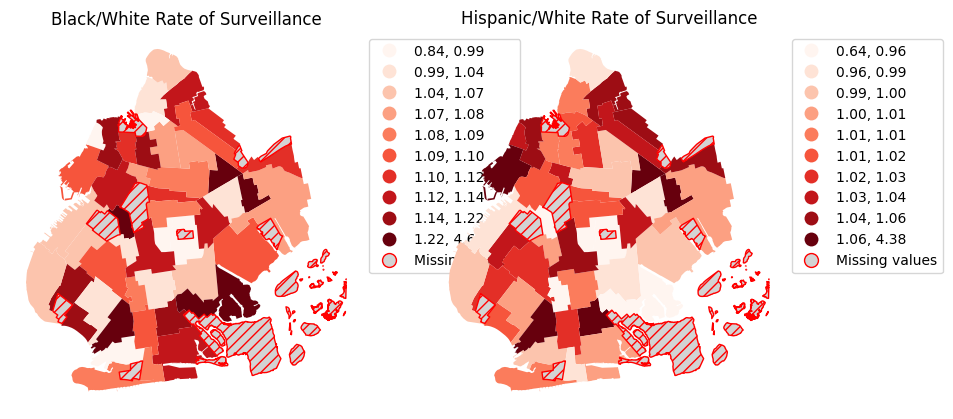

In [224]:
fig, ax = plt.subplots(1,2,figsize = (10,10))
nta_surv_sample.plot(column = 'Black/White_Surv_Rate',ax = ax[0],cmap='Reds', legend = True,k = 10, scheme = 'Quantiles',
                missing_kwds={"color": "lightgrey", ## what to do with missing values
                                 "edgecolor": "red",
                                 "hatch": "///",
                                 "label": "Missing values",}
             ,legend_kwds={'bbox_to_anchor': (1, 1),'loc': 'upper left'})
nta_surv_sample.plot(column = 'Hispanic/White_Surv_Rate',ax = ax[1],cmap='Reds', legend = True,k = 10, scheme = 'Quantiles',
                missing_kwds={"color": "lightgrey", ## what to do with missing values
                                 "edgecolor": "red",
                                 "hatch": "///",
                                 "label": "Missing values",}
             ,legend_kwds={'bbox_to_anchor': (1, 1),'loc': 'upper left'})
ax[0].axis('off')
ax[0].set_title('Black/White Rate of Surveillance')
ax[1].axis('off')
ax[1].set_title('Hispanic/White Rate of Surveillance')
plt.show()

In [225]:
#save files
nta_surv_sample.to_file('../Outputs/nta_racial_ethnic_surveillance.shp')
nta_surv_sample.to_csv('../Outputs/nta_racial_ethnic_surveillance.csv')

In [164]:
values_per_row = []
#fill Nans
tract_demo_21 = tract_demo_21.fillna(0)
for i, row in tract_demo_21.iterrows():
    geometry = row['geometry']

    #initialize dictionary we will append to values_per_row list
    column_dict = {'GEOID': row['GEOID']}
    for race in race_col:
        num_points = row[race]
        # Sample points within the current tract
        points = sample_points_within_geom(geometry,num_points)

         # Initialize lists to store the values for each point
        values = []
        for point in points:
            # Perform the raster masking to extract values at the point
            masked_data, _ = mask(raster, [mapping(Point(point))], crop=True)

            # Flatten the masked data to a 1D array
            value = masked_data.flatten()
            values.append(value)

        # Compute the average and standard deviation of the values and add them to dictionary       
        column_dict[race+'_avg_surv'] = np.mean(values)
        column_dict[race+'_std_surv'] = np.std(values)
    
    values_per_row.append(column_dict)

ValueError: Input shapes do not overlap raster.

In [152]:
#Create a new GeoDataFrame from the results and join it with the original GeoDataFrame
results_df = pd.DataFrame(values_per_row)
tracts_surv_sample = tract_demo_21.merge(results_df, on='GEOID')
tracts_surv_sample.head()

,"White, not hispanic","Black or African American, not hispanic","Asain, not hispanic",Hispanic or Latino,tract_name,state_id,county_id,tract_id,GEOID,"Other Races, not hispanic",...,"White, not hispanic_avg_surv","White, not hispanic_std_surv","Black or African American, not hispanic_avg_surv","Black or African American, not hispanic_std_surv","Asain, not hispanic_avg_surv","Asain, not hispanic_std_surv",Hispanic or Latino_avg_surv,Hispanic or Latino_std_surv,"Other Races, not hispanic_avg_surv","Other Races, not hispanic_std_surv"
0,3174,677,287,384,Census Tract 1,36,047,000100,36047000100,200,...,3.134671e-09,3.282018e-09,3.020063e-09,3.305706e-09,3.143732e-09,3.252633e-09,3.253711e-09,3.298520e-09,3.118825e-09,3.270634e-09
1,249,23,55,833,Census Tract 2,36,047,000200,36047000200,0,...,1.993606e-09,2.272989e-09,1.780568e-09,2.107734e-09,2.023498e-09,2.147407e-09,2.287251e-09,2.286900e-09,NaN,NaN
2,3514,62,63,164,Census Tract 3.01,36,047,000301,36047000301,89,...,1.724174e-09,1.648012e-09,1.955071e-09,1.759002e-09,2.209229e-09,2.079652e-09,1.597362e-09,1.600680e-09,1.713406e-09,1.761330e-09
3,3022,233,593,561,Census Tract 5.01,36,047,000501,36047000501,195,...,1.804220e-09,3.152870e-09,1.675814e-09,3.078108e-09,1.851727e-09,3.175353e-09,1.991998e-09,3.293288e-09,2.033964e-09,3.242951e-09
4,2297,38,339,117,Census Tract 5.02,36,047,000502,36047000502,35,...,4.753842e-09,6.648576e-09,5.232110e-09,6.935592e-09,5.132073e-09,6.701201e-09,5.263847e-09,7.043341e-09,4.043452e-09,6.584238e-09


In [154]:
#fill nans
tracts_surv_sample = tracts_surv_sample.fillna(0)

In [166]:
tracts_surv_sample.columns

Index(['White, not hispanic', 'Black or African American, not hispanic',
       'Asain, not hispanic', 'Hispanic or Latino', 'tract_name', 'state_id',
       'county_id', 'tract_id', 'GEOID', 'Other Races, not hispanic',
       'CTLabel', 'BoroCode', 'BoroName', 'CT2020', 'BoroCT2020', 'CDEligibil',
       'NTAName', 'NTA2020', 'CDTA2020', 'CDTANAME', 'Shape_Leng',
       'Shape_Area', 'geometry', 'White, not hispanic_avg_surv',
       'White, not hispanic_std_surv',
       'Black or African American, not hispanic_avg_surv',
       'Black or African American, not hispanic_std_surv',
       'Asain, not hispanic_avg_surv', 'Asain, not hispanic_std_surv',
       'Hispanic or Latino_avg_surv', 'Hispanic or Latino_std_surv',
       'Other Races, not hispanic_avg_surv',
       'Other Races, not hispanic_std_surv'],
      dtype='object')

In [175]:
# Scale the columns
for column in race_col:
    avg_surv_column = f"{column}_avg_surv"
    std_surv_column = f"{column}_std_surv"
    
    data = np.asarray(tracts_surv_sample[avg_surv_column]).reshape(-1, 1)
    std_vals = np.asarray(tracts_surv_sample[std_surv_column]).reshape(-1, 1)
    
    scaler = MinMaxScaler()
    scaler.fit(data)
    
    tracts_surv_sample[avg_surv_column+'_scaled'] = scaler.transform(data)
    tracts_surv_sample[std_surv_column+'_scaled'] = scaler.transform(std_vals)
tracts_surv_sample.head()

,"White, not hispanic","Black or African American, not hispanic","Asain, not hispanic",Hispanic or Latino,tract_name,state_id,county_id,tract_id,GEOID,"Other Races, not hispanic",...,"Black or African American, not hispanic_avg_surv_scaled","Black or African American, not hispanic_std_surv_scaled","Asain, not hispanic_avg_surv_scaled","Asain, not hispanic_std_surv_scaled",Hispanic or Latino_avg_surv_scaled,Hispanic or Latino_std_surv_scaled,"Other Races, not hispanic_avg_surv_scaled","Other Races, not hispanic_std_surv_scaled",Black/White_Surv_Rate,Hispanic/White_Surv_Rate
0,3174,677,287,384,Census Tract 1,36,047,000100,36047000100,200,...,0.163665,0.179145,0.157844,0.163311,0.164394,0.166658,0.148939,0.156189,0.908621,1.161067
1,249,23,55,833,Census Tract 2,36,047,000200,36047000200,0,...,0.096494,0.114224,0.101598,0.107819,0.115564,0.115546,0.000000,0.000000,1.057286,0.699220
2,3514,62,63,164,Census Tract 3.01,36,047,000301,36047000301,89,...,0.105950,0.095325,0.110923,0.104417,0.080707,0.080875,0.081824,0.084112,0.615650,1.206764
3,3022,233,593,561,Census Tract 5.01,36,047,000501,36047000501,195,...,0.090817,0.166811,0.092973,0.159431,0.100646,0.166394,0.097132,0.154867,0.946286,0.879461
4,2297,38,339,117,Census Tract 5.02,36,047,000502,36047000502,35,...,0.283542,0.375858,0.257676,0.336460,0.265956,0.355866,0.193095,0.314430,1.193785,1.242079


Text(0.5, 1.0, 'White Surveillance Metric')

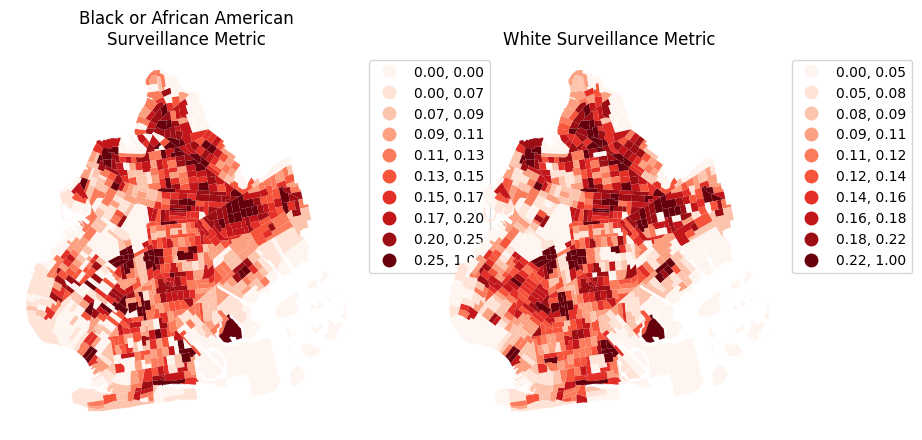

In [176]:
fig, ax = plt.subplots(1,2,figsize = (10,10))
tracts_surv_sample.plot(column = 'Black or African American, not hispanic_avg_surv_scaled',ax = ax[0],cmap='Reds', legend = True,k = 10, scheme = 'Quantiles',
                missing_kwds={"color": "lightgrey", ## what to do with missing values
                                 "edgecolor": "red",
                                 "hatch": "///",
                                 "label": "Missing values",}
             ,legend_kwds={'bbox_to_anchor': (1, 1),'loc': 'upper left'})
tracts_surv_sample.plot(column = 'White, not hispanic_avg_surv_scaled',ax = ax[1],cmap='Reds', legend = True,k = 10, scheme = 'Quantiles',
                missing_kwds={"color": "lightgrey", ## what to do with missing values
                                 "edgecolor": "red",
                                 "hatch": "///",
                                 "label": "Missing values",}
             ,legend_kwds={'bbox_to_anchor': (1, 1),'loc': 'upper left'})
ax[0].axis('off')
ax[0].set_title('Black or African American\nSurveillance Metric')
ax[1].axis('off')
ax[1].set_title('White Surveillance Metric')


In [177]:
tracts_surv_sample['Black/White_Surv_Rate'] = tracts_surv_sample['Black or African American, not hispanic_avg_surv_scaled']/tracts_surv_sample['White, not hispanic_avg_surv_scaled']
tracts_surv_sample['Hispanic/White_Surv_Rate'] = tracts_surv_sample['Hispanic or Latino_avg_surv_scaled']/tracts_surv_sample['White, not hispanic_avg_surv_scaled']

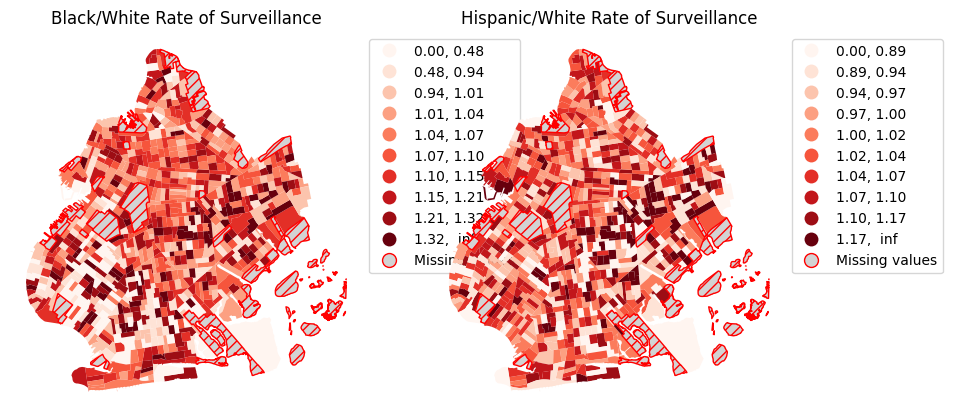

In [178]:
fig, ax = plt.subplots(1,2,figsize = (10,10))
tracts_surv_sample.plot(column = 'Black/White_Surv_Rate',ax = ax[0],cmap='Reds', legend = True,k = 10, scheme = 'Quantiles',
                missing_kwds={"color": "lightgrey", ## what to do with missing values
                                 "edgecolor": "red",
                                 "hatch": "///",
                                 "label": "Missing values",}
             ,legend_kwds={'bbox_to_anchor': (1, 1),'loc': 'upper left'})
tracts_surv_sample.plot(column = 'Hispanic/White_Surv_Rate',ax = ax[1],cmap='Reds', legend = True,k = 10, scheme = 'Quantiles',
                missing_kwds={"color": "lightgrey", ## what to do with missing values
                                 "edgecolor": "red",
                                 "hatch": "///",
                                 "label": "Missing values",}
             ,legend_kwds={'bbox_to_anchor': (1, 1),'loc': 'upper left'})
ax[0].axis('off')
ax[0].set_title('Black/White Rate of Surveillance')
ax[1].axis('off')
ax[1].set_title('Hispanic/White Rate of Surveillance')
plt.show()

In [179]:
#save tract info to shapefile
tracts_surv_sample.to_file('../Outputs/tract_racial_ethnic_surveillance.shp')
tracts_surv_sample.to_csv('../Outputs/tract_racial_ethnic_surveillance.csv')